# Variational AutoEncoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from vae import VariationalAutoencoder

### Import data (MNIST)

In [2]:
data = np.genfromtxt('train.csv', delimiter=',')

In [3]:
X = data[1:,1:]
y = data[1:,0]
X/=255
X = (X>0.5).astype(np.float32)

### Generate and train encoder

In [4]:
vae = VariationalAutoencoder(784, [200, 100])

In [5]:
vae.fit(X,epochs=8)

Epoch: 1
Cost: -8211346.257324219
Epoch: 2
Cost: -5835407.349609375
Epoch: 3
Cost: -5239869.599121094
Epoch: 4
Cost: -4861347.515136719
Epoch: 5
Cost: -4601323.0400390625
Epoch: 6
Cost: -4418973.1044921875
Epoch: 7
Cost: -4294501.0009765625
Epoch: 8
Cost: -4206551.357910156


### Reconstruction

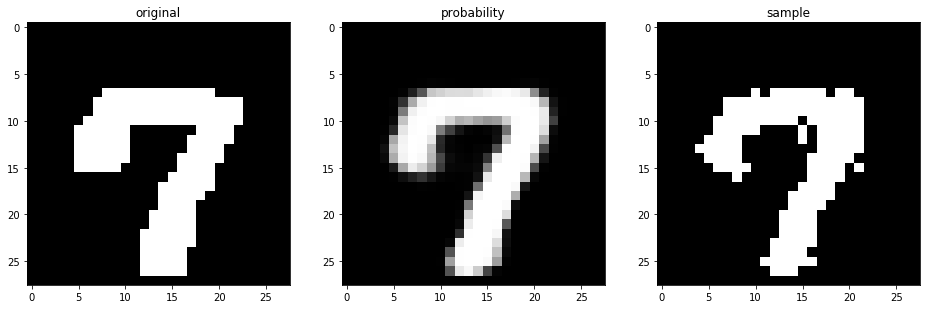

In [12]:
fig,axes = plt.subplots(ncols=3,figsize=(16,16))

i = np.random.choice(len(X))
aa = vae.predict(X[i:i+3])
a = aa[0].reshape(28,28)
b = vae.predict(X[i],'sample').reshape(28,28)

axes[0].imshow(X[i].reshape(28,28),cmap='gray')
axes[0].set_title('original')
axes[1].imshow(a,cmap='gray')
axes[1].set_title('probability')
axes[2].imshow(b,cmap='gray')
axes[2].set_title('sample')
plt.show()

### Generation

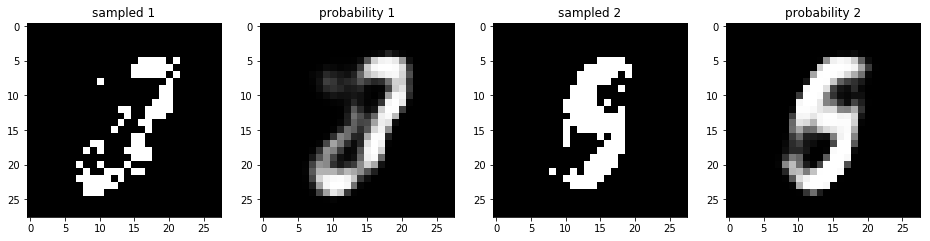

In [15]:
fig,axes = plt.subplots(ncols=4,figsize=(16,16))

c,d = vae.generate(2,'both')
a,b = c[0].reshape(28,28), d[0].reshape(28,28)
c,d = c[1].reshape(28,28), d[1].reshape(28,28)

axes[0].imshow(a,cmap='gray')
axes[0].set_title('sampled 1')
axes[1].imshow(b,cmap='gray')
axes[1].set_title('probability 1')
axes[2].imshow(c,cmap='gray')
axes[2].set_title('sampled 2')
axes[3].imshow(d,cmap='gray')
axes[3].set_title('probability 2')
plt.show()

### Manual input to latent space

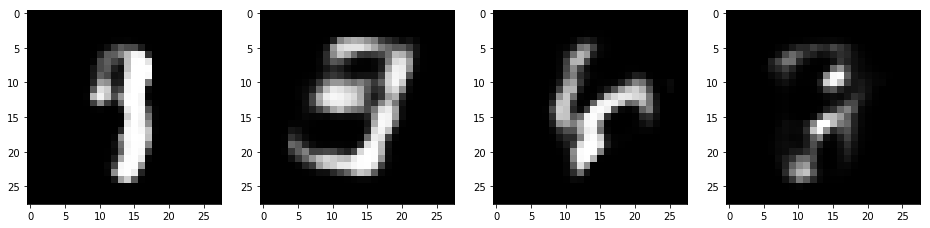

In [20]:
Z_input = np.random.normal(size=(4,100))

fig,axes = plt.subplots(ncols=4,figsize=(16,16))

g = vae.feed(Z_input)
a,b = g[0].reshape(28,28), g[1].reshape(28,28)
c,d = g[2].reshape(28,28), g[3].reshape(28,28)

axes[0].imshow(a,cmap='gray')
axes[1].imshow(b,cmap='gray')
axes[2].imshow(c,cmap='gray')
axes[3].imshow(d,cmap='gray')
plt.show()